In [34]:

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv("combined_data_v8_hw.csv", encoding="latin1").fillna(method="ffill")
data.head(10)

,Sentence #,Word,POS,Tag
0,1,A,DET,O
1,1,central,ADJ,B-hw
2,1,processing,NOUN,I-hw
3,1,unit,NOUN,I-hw
4,1,(,PUNCT,O
5,1,CPU,PROPN,B-hw
6,1,),PUNCT,O
7,1,",",PUNCT,O
8,1,also,ADV,O
9,1,called,VERB,O


In [35]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [36]:
getter = SentenceGetter(data)

In [37]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[1]

['A',
 'central',
 'processing',
 'unit',
 '(',
 'CPU',
 ')',
 ',',
 'also',
 'called',
 'a',
 'central',
 'processor',
 ',',
 'main',
 'processor',
 'or',
 'just',
 'processor',
 ',',
 'is',
 'the',
 'electronic',
 'circuitry',
 'that',
 'executes',
 'instructions',
 'comprising',
 'a',
 'computer',
 'program',
 '.']

In [38]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[1])

['O', 'B-hw', 'I-hw', 'I-hw', 'O', 'B-hw', 'O', 'O', 'O', 'O', 'O', 'B-hw', 'I-hw', 'O', 'B-hw', 'I-hw', 'O', 'O', 'B-hw', 'O', 'O', 'O', 'O', 'O', 'O', 'B-func', 'B-sw', 'O', 'O', 'B-sw', 'I-sw', 'O']


In [39]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [40]:
import pickle
with open('tag_values.pkl', 'wb') as f:
    pickle.dump(tag_values, f,)
print(tag_values)

with open('tag2idx.pkl', 'wb') as f:
    pickle.dump(tag2idx, f)
print(tag2idx)

['I-sys', 'B-unit', 'O', 'B-comp', 'I-hw', 'I-sw', 'B-mea', 'I-qt', 'I-comp', 'I-unit', 'B-hw', 'B-sw', 'B-func', 'B-sys', 'I-func', 'B-qt', 'I-mea', 'PAD']
{'I-sys': 0, 'B-unit': 1, 'O': 2, 'B-comp': 3, 'I-hw': 4, 'I-sw': 5, 'B-mea': 6, 'I-qt': 7, 'I-comp': 8, 'I-unit': 9, 'B-hw': 10, 'B-sw': 11, 'B-func': 12, 'B-sys': 13, 'I-func': 14, 'B-qt': 15, 'I-mea': 16, 'PAD': 17}


In [41]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


'2.0.0'

In [42]:
MAX_LEN = 75
bs = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_gpu = torch.cuda.device_count()


In [43]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [44]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [45]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [46]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [47]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [48]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


In [49]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [50]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


In [51]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [52]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [53]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__


'4.27.3'

In [54]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [55]:
model.cpu();

In [56]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


/opt/homebrew/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [57]:
from transformers import get_linear_schedule_with_warmup

epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [58]:
from seqeval.metrics import f1_score, accuracy_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [59]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.6195879207207606


Epoch:  10%|█         | 1/10 [02:13<20:04, 133.85s/it]

Validation loss: 0.25243342109024525
Validation Accuracy: 0.8299255247122546
Validation F1-Score: 0.3273657289002557

Average train loss: 0.1859290762589528


Epoch:  20%|██        | 2/10 [04:30<18:05, 135.65s/it]

Validation loss: 0.15065636485815048
Validation Accuracy: 0.8873392010832769
Validation F1-Score: 0.5826848249027238

Average train loss: 0.10364828488001457


Epoch:  30%|███       | 3/10 [06:46<15:50, 135.82s/it]

Validation loss: 0.11296654399484396
Validation Accuracy: 0.916723087339201
Validation F1-Score: 0.7244094488188976

Average train loss: 0.06420946986629412


Epoch:  40%|████      | 4/10 [09:03<13:37, 136.31s/it]

Validation loss: 0.09584503900259733
Validation Accuracy: 0.9310765064319567
Validation F1-Score: 0.7752011358258402

Average train loss: 0.045224270310539466


Epoch:  50%|█████     | 5/10 [11:21<11:23, 136.65s/it]

Validation loss: 0.10220586648210883
Validation Accuracy: 0.9316181448882871
Validation F1-Score: 0.7841328413284133

Average train loss: 0.03606030009686947


Epoch:  60%|██████    | 6/10 [13:35<09:03, 135.93s/it]

Validation loss: 0.09891776880249381
Validation Accuracy: 0.9348679756262694
Validation F1-Score: 0.7970135324311712

Average train loss: 0.030453791082478487


Epoch:  70%|███████   | 7/10 [15:51<06:48, 136.03s/it]

Validation loss: 0.10087584797292948
Validation Accuracy: 0.9364928909952607
Validation F1-Score: 0.8056206088992974

Average train loss: 0.02368169634674604


Epoch:  80%|████████  | 8/10 [18:07<04:31, 135.92s/it]

Validation loss: 0.09913469757884741
Validation Accuracy: 0.940419769803656
Validation F1-Score: 0.8110383536014967

Average train loss: 0.020474670354563455


Epoch:  90%|█████████ | 9/10 [20:22<02:15, 135.66s/it]

Validation loss: 0.09680084465071559
Validation Accuracy: 0.9415030467163169
Validation F1-Score: 0.8157894736842104

Average train loss: 0.02054607465576667


Epoch: 100%|██████████| 10/10 [22:38<00:00, 135.83s/it]

Validation loss: 0.09754696255549788
Validation Accuracy: 0.9420446851726473
Validation F1-Score: 0.8220973782771536



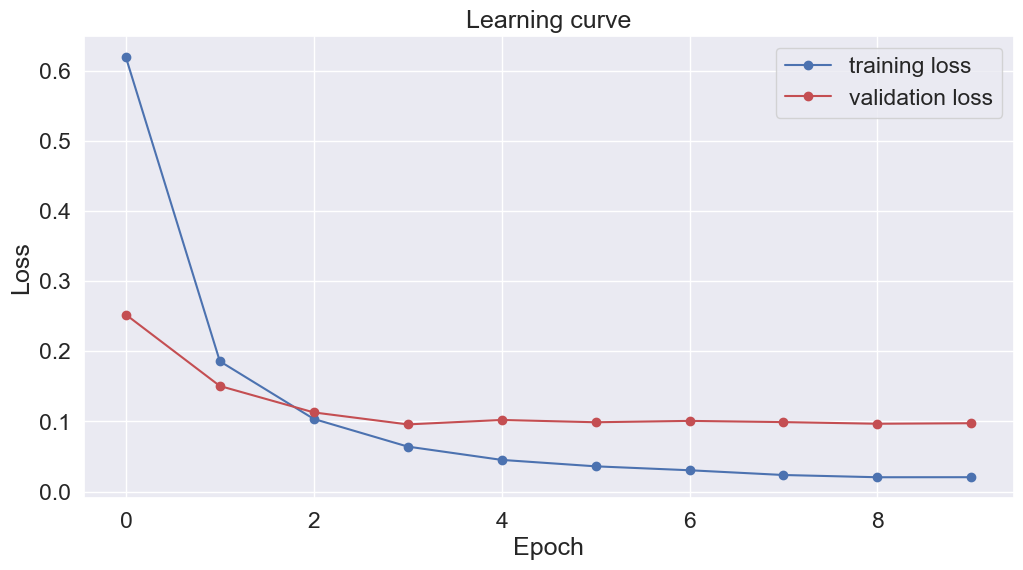

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [61]:
test_sentence = """
A central processing unit (CPU), also called a processor, main processor, or just processor, is the electronic circuitry that executes instructions comprising a computer program.
"""


In [62]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cpu()


In [63]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [64]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [65]:
finalResultOfTagging = {}
for token, label in zip(new_tokens, new_labels):
    finalResultOfTagging[token] = label
    # print("{}\t{}".format(label, token))

print(finalResultOfTagging)


{'[CLS]': 'O', 'A': 'O', 'central': 'B-hw', 'processing': 'I-hw', 'unit': 'I-hw', '(': 'O', 'CPU': 'B-hw', ')': 'O', ',': 'O', 'also': 'O', 'called': 'O', 'a': 'O', 'processor': 'B-hw', 'main': 'B-hw', 'or': 'O', 'just': 'O', 'is': 'O', 'the': 'O', 'electronic': 'O', 'circuitry': 'O', 'that': 'O', 'executes': 'B-func', 'instructions': 'B-sw', 'comprising': 'O', 'computer': 'B-sw', 'program': 'B-sw', '.': 'O', '[SEP]': 'O'}


In [66]:
model.save_pretrained('BERT_model_tagging_task_hw')